Trong Section 20.1, ta đã giới thiệu về những ý tưởng cơ bản ẩn sau cách hoạt động của GAN. Ta đã thấy được quá trình tạo mẫu từ các phân phối đơn giản, dễ-lấy-mẫu như phân phối đều hay phân phối chuẩn, và biến đổi chúng thành các mẫu phù hợp với phân phối của tập dữ liệu nào đó. Dù ví dụ cho GAN khớp với phân phối Gauss 2 chiều là một minh họa rõ ràng, nhưng nó không thật sự thú vị.

Trong phần này, chúng tôi sẽ trình bày cách dùng GAN để tạo ra những bức ảnh chân thực. Ta sẽ xây dựng mô hình dựa theo các mô hình GAN tích chập sâu (deep convolutional GAN - DCGAN) được giới thiệu trong [Radford et al., 2015]. Bằng cách mượn kiến trúc tích chập đã được chứng minh là thành công với bài toán thị giác máy tính phân biệt, và bằng cách thông qua GAN, ta có thể dùng chúng làm đòn bẩy để tạo ra các hình ảnh chân thực.

In [1]:
import warnings
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

# 20.2.1. Tập dữ liệu Pokemon

Ta sẽ sử dụng tập dữ liệu các nhân vật Pokemon từ pokemondb. Đầu tiên ta tải xuống, giải nén và nạp tập dữ liệu.

In [2]:
#@save
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

Ta thay đổi kích thước ảnh thành $64×64$. Phép biến đổi ToTensor sẽ chiếu từng giá trị điểm ảnh vào khoảng $[0,1]$, trong đó mạng sinh của ta sẽ dùng hàm tanh để thu được đầu ra trong khoảng $[−1,1]$. Do đó ta chuẩn hóa dữ liệu với trung bình $0.5$ và độ lệch chuẩn $0.5$ để khớp với miền giá trị.

In [3]:
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

Hãy xem thử 20 hình đầu tiên.

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


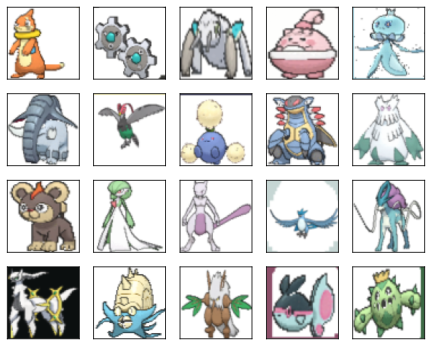

In [4]:
warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

# 20.2.2. Bộ Sinh

Bộ sinh sẽ ánh xạ biến nhiễu $z∈R^d$, một vector $d$ chiều sang hình ảnh RGB với chiều rộng và chiều cao tương ứng là $64×64$. Trong các phần trước đã giới thiệu về mạng tích chập đầy đủ, sử dụng tầng tích chập chuyển vị (tham khảo Section 13.10 - sách tiếng việt) để phóng to kích thước đầu vào. Khối cơ bản của bộ sinh gồm tầng tích chập chuyển vị, theo sau là chuẩn hóa theo batch và hàm kích hoạt ReLU.

In [5]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

Mặc định, tầng tích chập chuyển vị dùng hạt nhân $k_h=k_w=4$,sải bước $s_h=s_w=2$ và đệm $p_h=p_w=1$. Với kích thước đầu vào $n^′_h×n^′_w=16×16$, khối bộ sinh sẽ nhân đôi chiều rộng và chiều cao của đầu vào.
$$
\begin{split}\begin{aligned}
n_h^{'} \times n_w^{'} &= [(n_h k_h - (n_h-1)(k_h-s_h)- 2p_h] \times [(n_w k_w - (n_w-1)(k_w-s_w)- 2p_w]\\
  &= [(k_h + s_h (n_h-1)- 2p_h] \times [(k_w + s_w (n_w-1)- 2p_w]\\
  &= [(4 + 2 \times (16-1)- 2 \times 1] \times [(4 + 2 \times (16-1)- 2 \times 1]\\
  &= 32 \times 32 .\\
\end{aligned}\end{split}
$$

In [9]:
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape

torch.Size([2, 20, 32, 32])

Giả sử, ta đổi tầng tích chập chuyển vị này thành một hạt nhân $4×4$, sải bước $1×1$ và đệm không. Với kích thước đầu vào là $1×1$, chiều rộng và chiều cao của đầu ra sẽ tăng thêm 3 giá trị.

In [10]:
x = torch.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk(x).shape

torch.Size([2, 20, 4, 4])

Bộ sinh bao gồm bốn khối cơ bản thực hiện tăng cả chiều rộng và chiều cao của đầu vào từ 1 lên 32. Cùng lúc đó, nó trước tiên chiếu biến tiềm ẩn này về $64×8$ kênh, rồi giảm một nửa số kênh sau mỗi lần. Cuối cùng, một tầng tích chập chuyển vị được sử dụng để sinh đầu ra. Nó tăng gấp đôi chiều rộng và chiều cao để khớp với kích thước mong muốn $64×64$, và giảm kích thước kênh xuống $3$. Hàm kích hoạt tanh được áp dụng để đưa giá trị đầu ra về khoảng $(−1,1)$.

In [12]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8,
            strides=1, padding=0),                  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 64, 64)

Hãy sinh một biến tiềm ẩn có số chiều là 100 để xác thực kích thước đầu ra của bộ sinh.

In [13]:
x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

# 20.2.3. Bộ phân biệt

Bộ phân biệt là một mạng tích chập thông thường ngoại trừ việc nó dùng hàm kích hoạt ReLU rò rỉ. Với $α∈[0,1]$ cho trước, định nghĩa của nó là
$$
\begin{split}\textrm{ReLU rò rỉ}(x) = \begin{cases}x & \text{nếu}\ x > 0\\ \alpha x &\text{ngược lại}\end{cases}.\end{split}
$$
Như có thể thấy, nó là ReLU thông thường nếu $α=0$, và là hàm đồng nhất nếu $α=1$. Cho $α∈(0,1)$, ReLU rò rỉ là một hàm phi tuyến cho đầu ra khác không với giá trị đầu vào âm. Mục đích của hàm này là khắc phục vấn đề “ReLU chết”, khi mà một nơ-ron có thể luôn xuất giá trị âm và do đó không thể được cập nhật (gradient của ReLU luôn bằng 0).


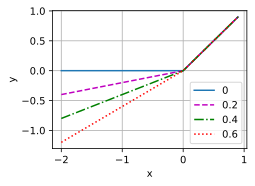

In [14]:
alphas = [0, .2, .4, .6, .8, 1]
x = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).detach().numpy() for alpha in alphas]
d2l.plot(x.detach().numpy(), Y, 'x', 'y', alphas)

Khối cơ bản của bộ phân biệt là một tầng tích chập, theo sau bởi tầng chuẩn hóa theo batch và một hàm kích hoạt ReLU rò rỉ. Các siêu tham số của tầng tích chập này tương tự như tầng tích chập chuyển vị trong khối sinh.

In [16]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

Khối cơ bản với thiết lập mặc định sẽ giảm một nửa chiều rộng và chiều cao của đầu vào, như ta đã chứng tỏ trong các phần trước. Chẳng hạn, cho kích thước đầu vào là $n_h=n_w=16$, với một hạt nhân có kích thước  $k_h=k_w=4$, sải bước $s_h=s_w=2$, và đệm $p_h=p_w=1$, kích thước đầu ra sẽ là:
$$
\begin{split}\begin{aligned}
n_h^{'} \times n_w^{'} &= \lfloor(n_h-k_h+2p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+2p_w+s_w)/s_w\rfloor\\
  &= \lfloor(16-4+2\times 1+2)/2\rfloor \times \lfloor(16-4+2\times 1+2)/2\rfloor\\
  &= 8 \times 8 .\\
\end{aligned}\end{split}
$$

In [17]:
x = torch.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk(x).shape

torch.Size([2, 20, 8, 8])

Bộ phân biệt là một tấm gương phản chiếu của bộ sinh.

In [18]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)

Nó sử dụng một tầng tích chập với kênh đầu ra  1
  làm tầng cuối cùng để có được giá trị dự đoán duy nhất.

In [19]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

# 20.2.4. Training 
So với mô hình GAN cơ bản trong Section 20.1, ta sử dụng cùng tốc độ học cho cả bộ sinh và bộ phân biệt do chúng tương đồng với nhau. Thêm nữa, ta thay đổi $β1$ trong Adam từ $0.9$ về $0.5$. Việc này làm giảm độ mượt của động lượng, tức là trung bình động trọng số mũ của các gradient trước đó, nhằm đáp ứng sự thay đổi nhanh chóng của gradient do bộ sinh và bộ phân biệt đối kháng lẫn nhau. Bên cạnh đó, nhiễu ngẫu nhiên Z là một tensor 4-D và ta sử dụng GPU để tăng tốc độ tính toán.

In [20]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

Ta sẽ chỉ huấn luyện mô hình với số epoch nhỏ để minh họa. Để đạt chất lượng mô hình tốt hơn, bạn có thể đặt biến `num_epochs` bằng một giá trị lớn hơn.

loss_D 0.005, loss_G 9.799, 428.4 examples/sec on cuda:0


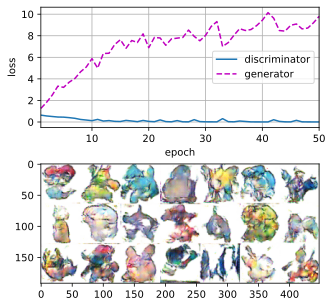

In [21]:
latent_dim, lr, num_epochs = 100, 0.005, 50
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)